# Feature extraction

- The goal of this project is to test the different classifiers  and techniques from the course using high-level features extracted with a pretrained convolutional neural network from TensorFlow Hub and compare the results with your own ConvNet implementation trained from the raw image pixels.
- Only the last model (i.e. ConvNet) should use the pixel values for computation

start by extracting a set of high-level features for each
image in the data set. To achieve this, you can use ex. the Inception v3 or MobileNet v2
ConvNets which respectively extract 2048 and 1280 high-level features.This high-level features should then be used for all of the tasks in this project, except for
when it is stated otherwise. 


- consider storing the extracted high-level features, e.g. in npz files, for quickly reloading them into each of the following notebooks. 

- You can find a general exampleof creating / loading .npz files in the course under "Applied Machine Learning 2 > 2K-nearest neighbors > Pickle and Numpy formats"

- For this project, you will first need to extract the high-level features into ex. X_{train, valid, test} Numpy arrays variables and save those using the code from the unit linked above.

### Extraction of the high-level features from MobileNet v2 

Apply transfer learning and exploit the fact that the MobileNet v2 model is more advanced and have been trained on
vast datasets.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
    feature_extractor = hub.Module(module_url)
    
    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
    
    # A node with the features
    imgs_features = feature_extractor(input_imgs)
    
    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])
    
img_graph.finalize()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
imgs_features.shape

TensorShape([Dimension(None), Dimension(1280)])

Insert Keras generators that read images from the disk for the train, valid and test. Obtain integer encoded labels (e.g. '1' instead of 'bike' in the orginial data set) with the iterator. It is much better to have the labels encoded as integers (single column) rather than one-hot encoding (6 columns) from the very beginning in order to avoid classification issues using sklearn models by interpreting different ways of labeling. 

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255, horizontal_flip=True, rotation_range=5)

valid_generator = ImageDataGenerator(rescale=1/255)

test_generator = ImageDataGenerator(rescale=1/255)

In [5]:
trainset = train_generator.flow_from_directory(
     'train', batch_size=32, target_size=(224, 224),
    shuffle=True, class_mode = 'sparse')
validset = valid_generator.flow_from_directory(
    'valid', batch_size=32, target_size=(224, 224),
    shuffle=False, class_mode = 'sparse')
testset = test_generator.flow_from_directory(
    'test', batch_size=32, target_size=(224, 224),
    shuffle=False, class_mode = 'sparse')

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [6]:
set(trainset.filenames).intersection(set(validset.filenames))

set()

Get the next batch of images with their labels:

In [7]:
batch_imgs, batch_labels = trainset.next()

print('Batch images:', batch_imgs.shape)
print('Batch labels:', batch_labels.shape)

Batch images: (32, 224, 224, 3)
Batch labels: (32,)


In [8]:
batch_labels

array([1., 3., 1., 1., 0., 2., 4., 0., 3., 0., 0., 1., 4., 4., 1., 3., 2.,
       1., 5., 4., 1., 2., 4., 1., 2., 2., 1., 3., 2., 1., 0., 5.],
      dtype=float32)

Original class names:

In [9]:
trainset.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

In [10]:
trainset.num_classes

6

Extract the features in smaller batches and add them to the same list:

In [11]:
X_train = []
X_valid = []
X_test = []

for i in range(len(trainset)):
    batch_imgs, batch_labels = trainset.next()
    X_train.extend(batch_imgs)

for i in range(len(validset)):
    batch_imgs, batch_labels = validset.next()
    X_valid.extend(batch_imgs)

for i in range(len(testset)):
    batch_imgs, batch_labels = testset.next()
    X_test.extend(batch_imgs)

In [12]:
sess = tf.Session(graph=img_graph)
sess.run(init_op)

# Extract features
features_train = sess.run(imgs_features, feed_dict={input_imgs: X_train})
features_train.shape

(280, 1280)

In [13]:
sess = tf.Session(graph=img_graph)
sess.run(init_op)

# Extract features
features_valid = sess.run(imgs_features, feed_dict={input_imgs: X_valid})
features_valid.shape

(139, 1280)

In [14]:
sess = tf.Session(graph=img_graph)
sess.run(init_op)

# Extract features
features_test = sess.run(imgs_features, feed_dict={input_imgs: X_test})
features_test.shape

(50, 1280)

The feature vector size is written in the MobileNet V2 module page. In this case, it's a vector with 1,280 values that we can now use as a high-level representation in our machine learning tasks ex. image classification, clustering, etc. We can see that our network returned positive values and that most of the features are very small.

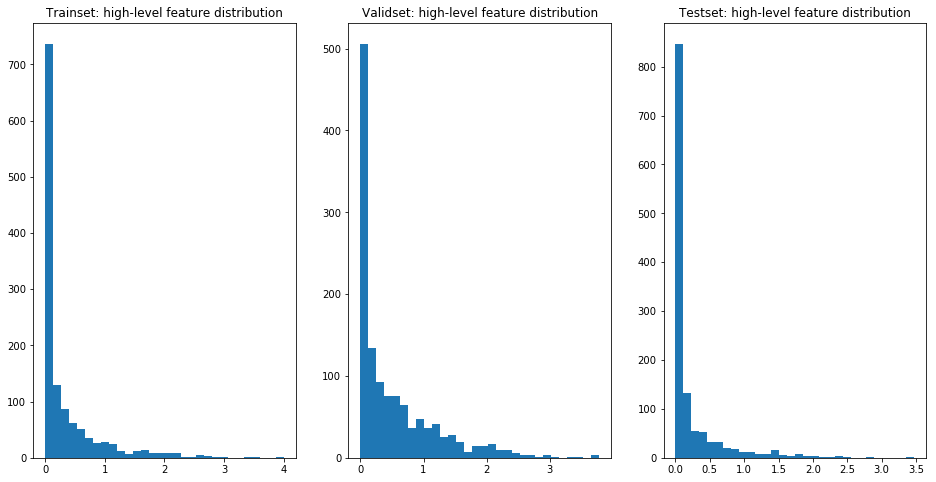

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

axes[0].hist(features_train[0], bins=30)
axes[0].set_title('Trainset: high-level feature distribution')

axes[1].hist(features_valid[0], bins=30)
axes[1].set_title('Validset: high-level feature distribution')

axes[2].hist(features_test[0], bins=30)
axes[2].set_title('Testset: high-level feature distribution')

plt.show()

Extract the high-level features into ex. X_{train, valid, test} Numpy arrays variables and save into a npz file:

In [18]:
import pickle
import numpy as np

In [19]:
# Save the features and labels into .npz files
np.savez('train.npz', features=features_train, targets=trainset.classes)
np.savez('valid.npz', features=features_valid, targets=validset.classes)
np.savez('test.npz', features=features_test, targets=testset.classes)

Load the arrays into an x and a y variable inside the with statement because Python closes the data.npz file after the last line of the with statement and we cannot read anymore its content:

In [20]:
with np.load('train.npz', allow_pickle=False) as npz_file:
    print(list(npz_file.keys()))
    # Load the arrays
    x = npz_file['features']
    y = npz_file['targets']
    
print('x:', x)
print('y:', y)

['features', 'targets']
x: [[0.60111076 1.2158889  0.         ... 0.3017757  0.         0.01815591]
 [0.22400282 0.436434   0.77965593 ... 0.06292479 0.         0.07810001]
 [0.91664886 1.6306     0.01359991 ... 0.4489011  0.15288512 0.        ]
 ...
 [0.95758915 0.31207407 0.44082472 ... 0.45021233 0.8905929  0.        ]
 [0.6478935  0.4861869  0.0075399  ... 0.         0.         0.52920437]
 [1.0656173  2.7841268  0.21541798 ... 0.01128208 0.         0.59357   ]]
y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5
 

In [21]:
with np.load('valid.npz', allow_pickle=False) as npz_file:
    print(list(npz_file.keys()))
    # Load the arrays
    x_valid = npz_file['features']
    y_valid = npz_file['targets']
    
print('x_valid:', x_valid)
print('y_valid:', y_valid)

['features', 'targets']
x_valid: [[1.09401548e+00 9.27886213e-05 1.07716374e-01 ... 0.00000000e+00
  4.30678539e-02 0.00000000e+00]
 [4.22967300e-02 5.20349801e-01 7.99242035e-02 ... 4.39764149e-02
  0.00000000e+00 6.98618412e-01]
 [1.12324441e-02 7.67907441e-01 6.04033768e-01 ... 4.05907452e-01
  0.00000000e+00 1.24343288e+00]
 ...
 [2.73414534e-02 0.00000000e+00 1.13507099e-02 ... 0.00000000e+00
  1.49869227e+00 2.43480830e-03]
 [4.10406943e-03 7.48322951e-03 1.43061848e-02 ... 0.00000000e+00
  1.37576861e-02 1.12666693e-02]
 [3.57184082e-01 0.00000000e+00 0.00000000e+00 ... 1.63174793e-01
  1.47952592e+00 0.00000000e+00]]
y_valid: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5]


In [22]:
with np.load('test.npz', allow_pickle=False) as npz_file:
    print(list(npz_file.keys()))
    # Load the arrays
    x_test = npz_file['features']
    y_test = npz_file['targets']
    
print('x_test:', x_test)
print('y_test:', y_test)

['features', 'targets']
x_test: [[0.29144996 0.22876674 0.07972695 ... 0.         0.         0.71062976]
 [0.31160155 0.03422425 0.         ... 0.         0.         1.6426007 ]
 [0.32524595 0.6716555  0.20074673 ... 0.21926497 0.         1.1482638 ]
 ...
 [0.04735842 0.10354836 0.         ... 0.06827842 1.6214066  0.1305886 ]
 [0.71848965 0.88224953 0.23294441 ... 0.0484273  0.07042809 0.2750796 ]
 [0.         0.         0.         ... 0.         0.2249395  0.06894732]]
y_test: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 4 4 4 4 4 4 4 5 5 5 5 5]
